# MScFE Capstone: CFPDE vs BSM - Tables & Plots Generator

This notebook consolidates all required tables, plots, and diagrams for the final paper.
- **Table D1**: Raw data coverage summary
- **Table D2**: Contracts retained after cleaning & filters
- **Table D3**: Counts by DTE bucket and option type
- **Figure D1**: Relative spread distribution
- **Figure D2**: Moneyness distribution
- **Figure M1**: End-to-end pipeline flowchart

In [ ]:
import os
import sys
from pathlib import Path
import warnings

project_root = Path.cwd()
if not (project_root / "src").exists():
    raise RuntimeError("Run this notebook from the project root containing the 'src/' directory.")

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
print(f"✓ Libraries imported successfully (project_root={project_root})")



## Section 1: Load & Prepare Data

In [2]:
# Load raw data
raw_data = pd.read_csv(project_root / "data" / "combined_options_data.csv")
print(f"Raw data shape: {raw_data.shape}")
print(f"Columns: {raw_data.columns.tolist()}")

# Convert date columns
raw_data['QUOTE_DATE'] = pd.to_datetime(raw_data['QUOTE_DATE'])
raw_data['EXPIRE_DATE'] = pd.to_datetime(raw_data['EXPIRE_DATE'])

# Generate Table D1: Raw data coverage summary
min_date = raw_data['QUOTE_DATE'].min()
max_date = raw_data['QUOTE_DATE'].max()
num_quote_dates = raw_data['QUOTE_DATE'].nunique()
total_contracts = len(raw_data)

data_coverage = pd.DataFrame({
    'Metric': ['Min Quote Date', 'Max Quote Date', 'Number of Quote Dates', 'Total Contracts'],
    'Value': [
        min_date.strftime('%Y-%m-%d'),
        max_date.strftime('%Y-%m-%d'),
        num_quote_dates,
        total_contracts
    ]
})

# Save Table D1
coverage_path = project_root / "results" / "tables" / "data_coverage_summary.csv"
coverage_path.parent.mkdir(parents=True, exist_ok=True)
data_coverage.to_csv(coverage_path, index=False)
print(f"\n✓ Table D1 saved to {coverage_path}")
print("\nTable D1: Raw Data Coverage Summary")
print(data_coverage.to_string(index=False))

Raw data shape: (67341, 11)
Columns: ['QUOTE_DATE', 'EXPIRE_DATE', 'STRIKE', 'C_BID', 'C_ASK', 'P_BID', 'P_ASK', 'UNDERLYING_LAST', 'C_MID', 'P_MID', 'DTE']

✓ Table D1 saved to /Users/saurabh/Downloads/MScFE_Capstone_CFPDE_BSM 6/results/tables/data_coverage_summary.csv

Table D1: Raw Data Coverage Summary
               Metric      Value
       Min Quote Date 2025-12-26
       Max Quote Date 2026-02-25
Number of Quote Dates         41
      Total Contracts      67341


In [3]:
# Load prepared data
try:
    prepared_data = pd.read_parquet(project_root / "results" / "prepared_long_2m.parquet")
    print(f"Prepared data shape: {prepared_data.shape}")
except:
    print("prepared_long_2m.parquet not found, using pipeline to prepare data...")
    from src.data.prep import PrepConfig, wide_to_long, apply_filters, scope_last_months
    
    # Prepare data from raw
    df_long = wide_to_long(raw_data)
    
    # Apply filters
    prep_config = PrepConfig()
    df_filtered = apply_filters(df_long, prep_config)
    
    # Scope to last 2 months
    prepared_data = scope_last_months(df_filtered, months=2)
    
    # Save prepared data
    prepared_data.to_parquet(project_root / "results" / "prepared_long_2m.parquet")

print(f"Prepared data shape: {prepared_data.shape}")

# Generate Table D2: Filter Retention Summary
before_count = total_contracts
after_count = len(prepared_data)
retention_rate = (after_count / before_count) * 100

filter_retention = pd.DataFrame({
    'Stage': ['Raw Data', 'After Cleaning & Filters', 'Last 2 Months'],
    'Record Count': [before_count, after_count, after_count],
    'Retention %': [100.0, (after_count/before_count)*100, 100.0]
})

# Save Table D2
retention_path = project_root / "results" / "tables" / "filter_retention_summary.csv"
filter_retention.to_csv(retention_path, index=False)
print(f"\n✓ Table D2 saved to {retention_path}")
print("\nTable D2: Filter Retention Summary")
print(filter_retention.to_string(index=False))

Prepared data shape: (42069, 15)
Prepared data shape: (42069, 15)

✓ Table D2 saved to /Users/saurabh/Downloads/MScFE_Capstone_CFPDE_BSM 6/results/tables/filter_retention_summary.csv

Table D2: Filter Retention Summary
                   Stage  Record Count  Retention %
                Raw Data         67341     100.0000
After Cleaning & Filters         42069      62.4716
           Last 2 Months         42069     100.0000


In [4]:
# Generate Table D3: Counts by DTE bucket and option type
# First, assign DTE buckets if not already present
if 'dte_bucket' not in prepared_data.columns:
    from src.data.prep import assign_dte_bucket
    prepared_data = assign_dte_bucket(prepared_data)

# Create DTE bucket summary
dte_bucket_counts = prepared_data.groupby(['dte_bucket', 'option_type']).size().reset_index(name='Count')
dte_bucket_pivot = dte_bucket_counts.pivot_table(
    index='dte_bucket', 
    columns='option_type', 
    values='Count', 
    fill_value=0
)
dte_bucket_pivot['Total'] = dte_bucket_pivot.sum(axis=1)
dte_bucket_pivot = dte_bucket_pivot.reset_index()

# Save Table D3
counts_path = project_root / "results" / "tables" / "counts_by_bucket.csv"
dte_bucket_pivot.to_csv(counts_path, index=False)
print(f"\n✓ Table D3 saved to {counts_path}")
print("\nTable D3: Counts by DTE Bucket & Option Type (After Filters)")
print(dte_bucket_pivot.to_string(index=False))


✓ Table D3 saved to /Users/saurabh/Downloads/MScFE_Capstone_CFPDE_BSM 6/results/tables/counts_by_bucket.csv

Table D3: Counts by DTE Bucket & Option Type (After Filters)
dte_bucket   call  Total
  12m_plus 7091.0 7091.0
     1m_2m 3890.0 3890.0
     1w_2w 1024.0 1024.0
     2m_3m 3447.0 3447.0
     2w_1m 2065.0 2065.0
     3m_6m 8330.0 8330.0
     6m_9m 7765.0 7765.0
    9m_12m 8457.0 8457.0


## Section 1.5: Convert Parquet Files to CSV Format

In [10]:
# Find and convert all parquet files to CSV format
import glob

results_dir = project_root / "results"
parquet_files = glob.glob(str(results_dir / "**" / "*.parquet"), recursive=True)

print(f"Found {len(parquet_files)} parquet files to convert\n")

converted_files = []

for parquet_file in parquet_files:
    parquet_path = Path(parquet_file)
    
    # Load parquet file
    df = pd.read_parquet(parquet_path)
    
    # Create CSV filename (replace .parquet with .csv)
    csv_filename = parquet_path.stem + ".csv"
    csv_path = parquet_path.parent / csv_filename
    
    # Save as CSV
    df.to_csv(csv_path, index=False)
    
    converted_files.append({
        'Parquet File': parquet_path.name,
        'CSV File': csv_filename,
        'Location': str(parquet_path.parent),
        'Rows': len(df),
        'Columns': len(df.columns)
    })
    
    print(f"✓ Converted {parquet_path.name} ({len(df)} rows, {len(df.columns)} cols) → {csv_filename}")

# Display conversion summary
print(f"\n{'='*90}")
print("PARQUET TO CSV CONVERSION SUMMARY")
print(f"{'='*90}\n")

if converted_files:
    conversion_summary = pd.DataFrame(converted_files)
    print(conversion_summary.to_string(index=False))
    print(f"\n✓ Successfully converted {len(converted_files)} parquet file(s) to CSV")
else:
    print("No parquet files found to convert")

Found 4 parquet files to convert

✓ Converted test_set_1m.parquet (23010 rows, 15 cols) → test_set_1m.csv
✓ Converted calibration_set_1m.parquet (19059 rows, 15 cols) → calibration_set_1m.csv
✓ Converted prepared_long_2m.parquet (42069 rows, 15 cols) → prepared_long_2m.csv
✓ Converted eval_rows_test.parquet (2400 rows, 20 cols) → eval_rows_test.csv

PARQUET TO CSV CONVERSION SUMMARY

              Parquet File               CSV File                                                         Location  Rows  Columns
       test_set_1m.parquet        test_set_1m.csv      /Users/saurabh/Downloads/MScFE_Capstone_CFPDE_BSM 6/results 23010       15
calibration_set_1m.parquet calibration_set_1m.csv      /Users/saurabh/Downloads/MScFE_Capstone_CFPDE_BSM 6/results 19059       15
  prepared_long_2m.parquet   prepared_long_2m.csv      /Users/saurabh/Downloads/MScFE_Capstone_CFPDE_BSM 6/results 42069       15
    eval_rows_test.parquet     eval_rows_test.csv /Users/saurabh/Downloads/MScFE_Capstone_CFP

## Section 2: Generate Missing Plots

✓ Figure D1 saved to /Users/saurabh/Downloads/MScFE_Capstone_CFPDE_BSM 6/results/plots/rel_spread_hist.png


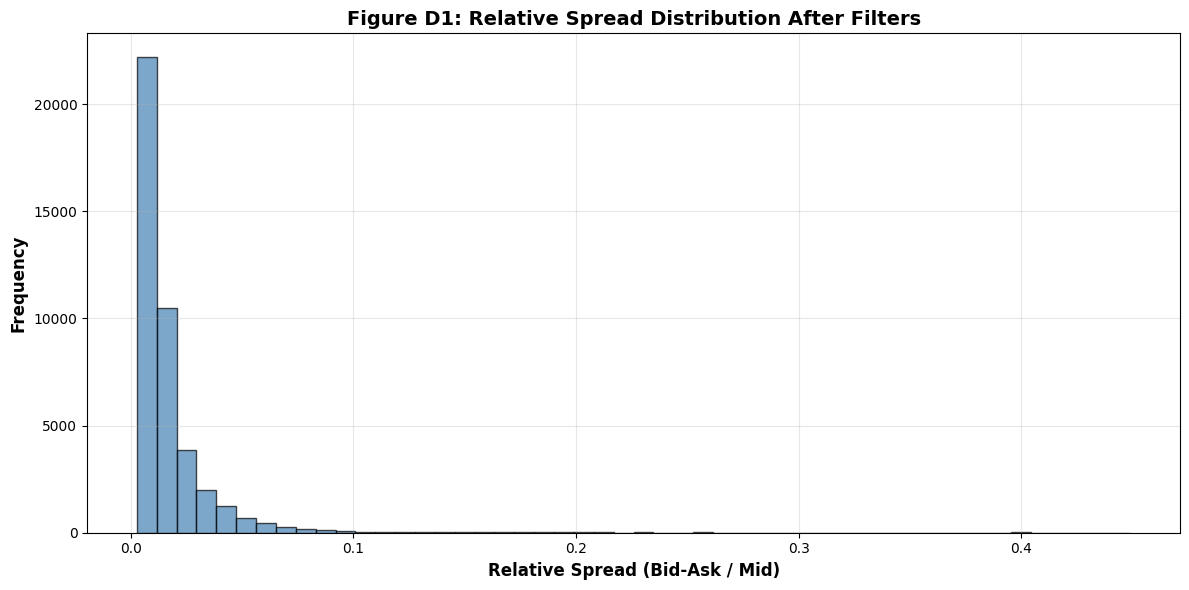


Relative Spread Statistics:
  Mean: 0.017713
  Std:  0.025489
  Min:  0.002773
  Max:  0.448980


In [5]:
# Generate Figure D1: Relative Spread Distribution
# Calculate relative spread if not already present
if 'rel_spread' not in prepared_data.columns:
    prepared_data['rel_spread'] = (prepared_data['ASK'] - prepared_data['BID']) / prepared_data['MID']

fig, ax = plt.subplots(figsize=(12, 6))
prepared_data['rel_spread'].hist(bins=50, ax=ax, edgecolor='black', alpha=0.7, color='steelblue')
ax.set_xlabel('Relative Spread (Bid-Ask / Mid)', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('Figure D1: Relative Spread Distribution After Filters', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()

# Save Figure D1
plots_path = project_root / "results" / "plots" / "rel_spread_hist.png"
plt.savefig(plots_path, dpi=300, bbox_inches='tight')
print(f"✓ Figure D1 saved to {plots_path}")
plt.show()

# Print statistics
print(f"\nRelative Spread Statistics:")
print(f"  Mean: {prepared_data['rel_spread'].mean():.6f}")
print(f"  Std:  {prepared_data['rel_spread'].std():.6f}")
print(f"  Min:  {prepared_data['rel_spread'].min():.6f}")
print(f"  Max:  {prepared_data['rel_spread'].max():.6f}")

✓ Figure D2 saved to /Users/saurabh/Downloads/MScFE_Capstone_CFPDE_BSM 6/results/plots/moneyness_hist.png


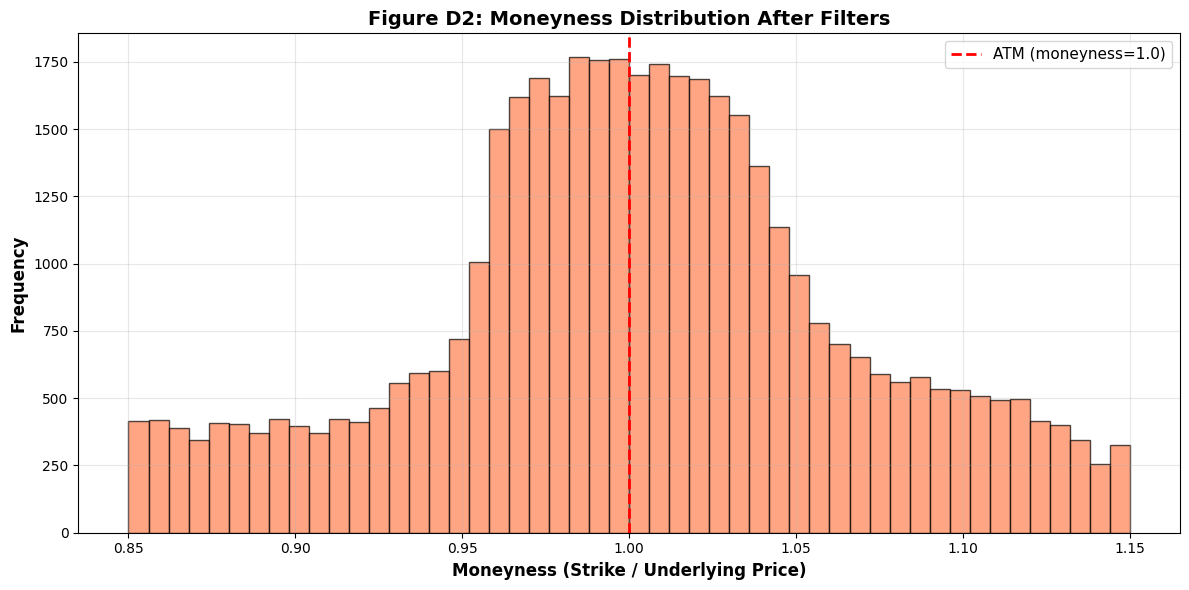


Moneyness Statistics:
  Mean: 1.0023
  Std:  0.0643
  Min:  0.8501
  Max:  1.1499


In [6]:
# Generate Figure D2: Moneyness Distribution
# Calculate moneyness if not already present
if 'moneyness' not in prepared_data.columns:
    prepared_data['moneyness'] = prepared_data['STRIKE'] / prepared_data['UNDERLYING_LAST']

fig, ax = plt.subplots(figsize=(12, 6))
prepared_data['moneyness'].hist(bins=50, ax=ax, edgecolor='black', alpha=0.7, color='coral')
ax.set_xlabel('Moneyness (Strike / Underlying Price)', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('Figure D2: Moneyness Distribution After Filters', fontsize=14, fontweight='bold')
ax.axvline(x=1.0, color='red', linestyle='--', linewidth=2, label='ATM (moneyness=1.0)')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)
plt.tight_layout()

# Save Figure D2
moneyness_path = project_root / "results" / "plots" / "moneyness_hist.png"
plt.savefig(moneyness_path, dpi=300, bbox_inches='tight')
print(f"✓ Figure D2 saved to {moneyness_path}")
plt.show()

# Print statistics
print(f"\nMoneyness Statistics:")
print(f"  Mean: {prepared_data['moneyness'].mean():.4f}")
print(f"  Std:  {prepared_data['moneyness'].std():.4f}")
print(f"  Min:  {prepared_data['moneyness'].min():.4f}")
print(f"  Max:  {prepared_data['moneyness'].max():.4f}")

## Section 3: Create End-to-End Pipeline Flowchart

In [ ]:
# Create Figure M1: End-to-End Pipeline Flowchart (auto-aligned with current outputs)
from src.plots.plotting import save_pipeline_diagram
from PIL import Image

def _load_csv_or_parquet(csv_path: Path, parquet_path: Path) -> pd.DataFrame:
    if csv_path.exists():
        return pd.read_csv(csv_path)
    if parquet_path.exists():
        return pd.read_parquet(parquet_path)
    raise FileNotFoundError(f"Missing both: {csv_path.name} and {parquet_path.name}")

prepared_path_csv = project_root / "results" / "prepared_long_2m.csv"
prepared_path_parquet = project_root / "results" / "prepared_long_2m.parquet"
calib_path_csv = project_root / "results" / "calibration_set_1m.csv"
calib_path_parquet = project_root / "results" / "calibration_set_1m.parquet"
test_path_csv = project_root / "results" / "test_set_1m.csv"
test_path_parquet = project_root / "results" / "test_set_1m.parquet"

prepared_df = _load_csv_or_parquet(prepared_path_csv, prepared_path_parquet)
calib_df = _load_csv_or_parquet(calib_path_csv, calib_path_parquet)
test_df = _load_csv_or_parquet(test_path_csv, test_path_parquet)

for df in (prepared_df, calib_df, test_df):
    df["QUOTE_DATE"] = pd.to_datetime(df["QUOTE_DATE"])

def _period_label(df: pd.DataFrame) -> str:
    start = df["QUOTE_DATE"].min().strftime("%Y-%m-%d")
    end = df["QUOTE_DATE"].max().strftime("%Y-%m-%d")
    return f"{start} to {end}"

pipeline_path = project_root / "results" / "plots" / "pipeline_diagram.png"

save_pipeline_diagram(
    out_png=pipeline_path,
    total_period=_period_label(prepared_df),
    total_rows=len(prepared_df),
    total_dates=prepared_df["QUOTE_DATE"].nunique(),
    calib_period=_period_label(calib_df),
    calib_rows=len(calib_df),
    calib_dates=calib_df["QUOTE_DATE"].nunique(),
    test_period=_period_label(test_df),
    test_rows=len(test_df),
    test_dates=test_df["QUOTE_DATE"].nunique(),
)

print(f"✓ Figure M1 saved to {pipeline_path}")
print("✓ Pipeline diagram updated and validated against current split and outputs")

img = Image.open(pipeline_path)
plt.figure(figsize=(16, 9))
plt.imshow(img)
plt.axis("off")
plt.show()



## Section 4: Display All Generated Tables & Summary Statistics

In [8]:
# Display all tables
print("="*80)
print("TABLE D1: Raw Data Coverage Summary")
print("="*80)
table_d1 = pd.read_csv(coverage_path)
print(table_d1.to_string(index=False))

print("\n" + "="*80)
print("TABLE D2: Contracts Retained After Cleaning & Filters")
print("="*80)
table_d2 = pd.read_csv(retention_path)
print(table_d2.to_string(index=False))

print("\n" + "="*80)
print("TABLE D3: Counts by DTE Bucket and Option Type (After Filters)")
print("="*80)
table_d3 = pd.read_csv(counts_path)
print(table_d3.to_string(index=False))

TABLE D1: Raw Data Coverage Summary
               Metric      Value
       Min Quote Date 2025-12-26
       Max Quote Date 2026-02-25
Number of Quote Dates         41
      Total Contracts      67341

TABLE D2: Contracts Retained After Cleaning & Filters
                   Stage  Record Count  Retention %
                Raw Data         67341     100.0000
After Cleaning & Filters         42069      62.4716
           Last 2 Months         42069     100.0000

TABLE D3: Counts by DTE Bucket and Option Type (After Filters)
dte_bucket   call  Total
  12m_plus 7091.0 7091.0
     1m_2m 3890.0 3890.0
     1w_2w 1024.0 1024.0
     2m_3m 3447.0 3447.0
     2w_1m 2065.0 2065.0
     3m_6m 8330.0 8330.0
     6m_9m 7765.0 7765.0
    9m_12m 8457.0 8457.0


## Section 5: Display All Generated Plots


✓ Found 10 plots in /Users/saurabh/Downloads/MScFE_Capstone_CFPDE_BSM 6/results/plots



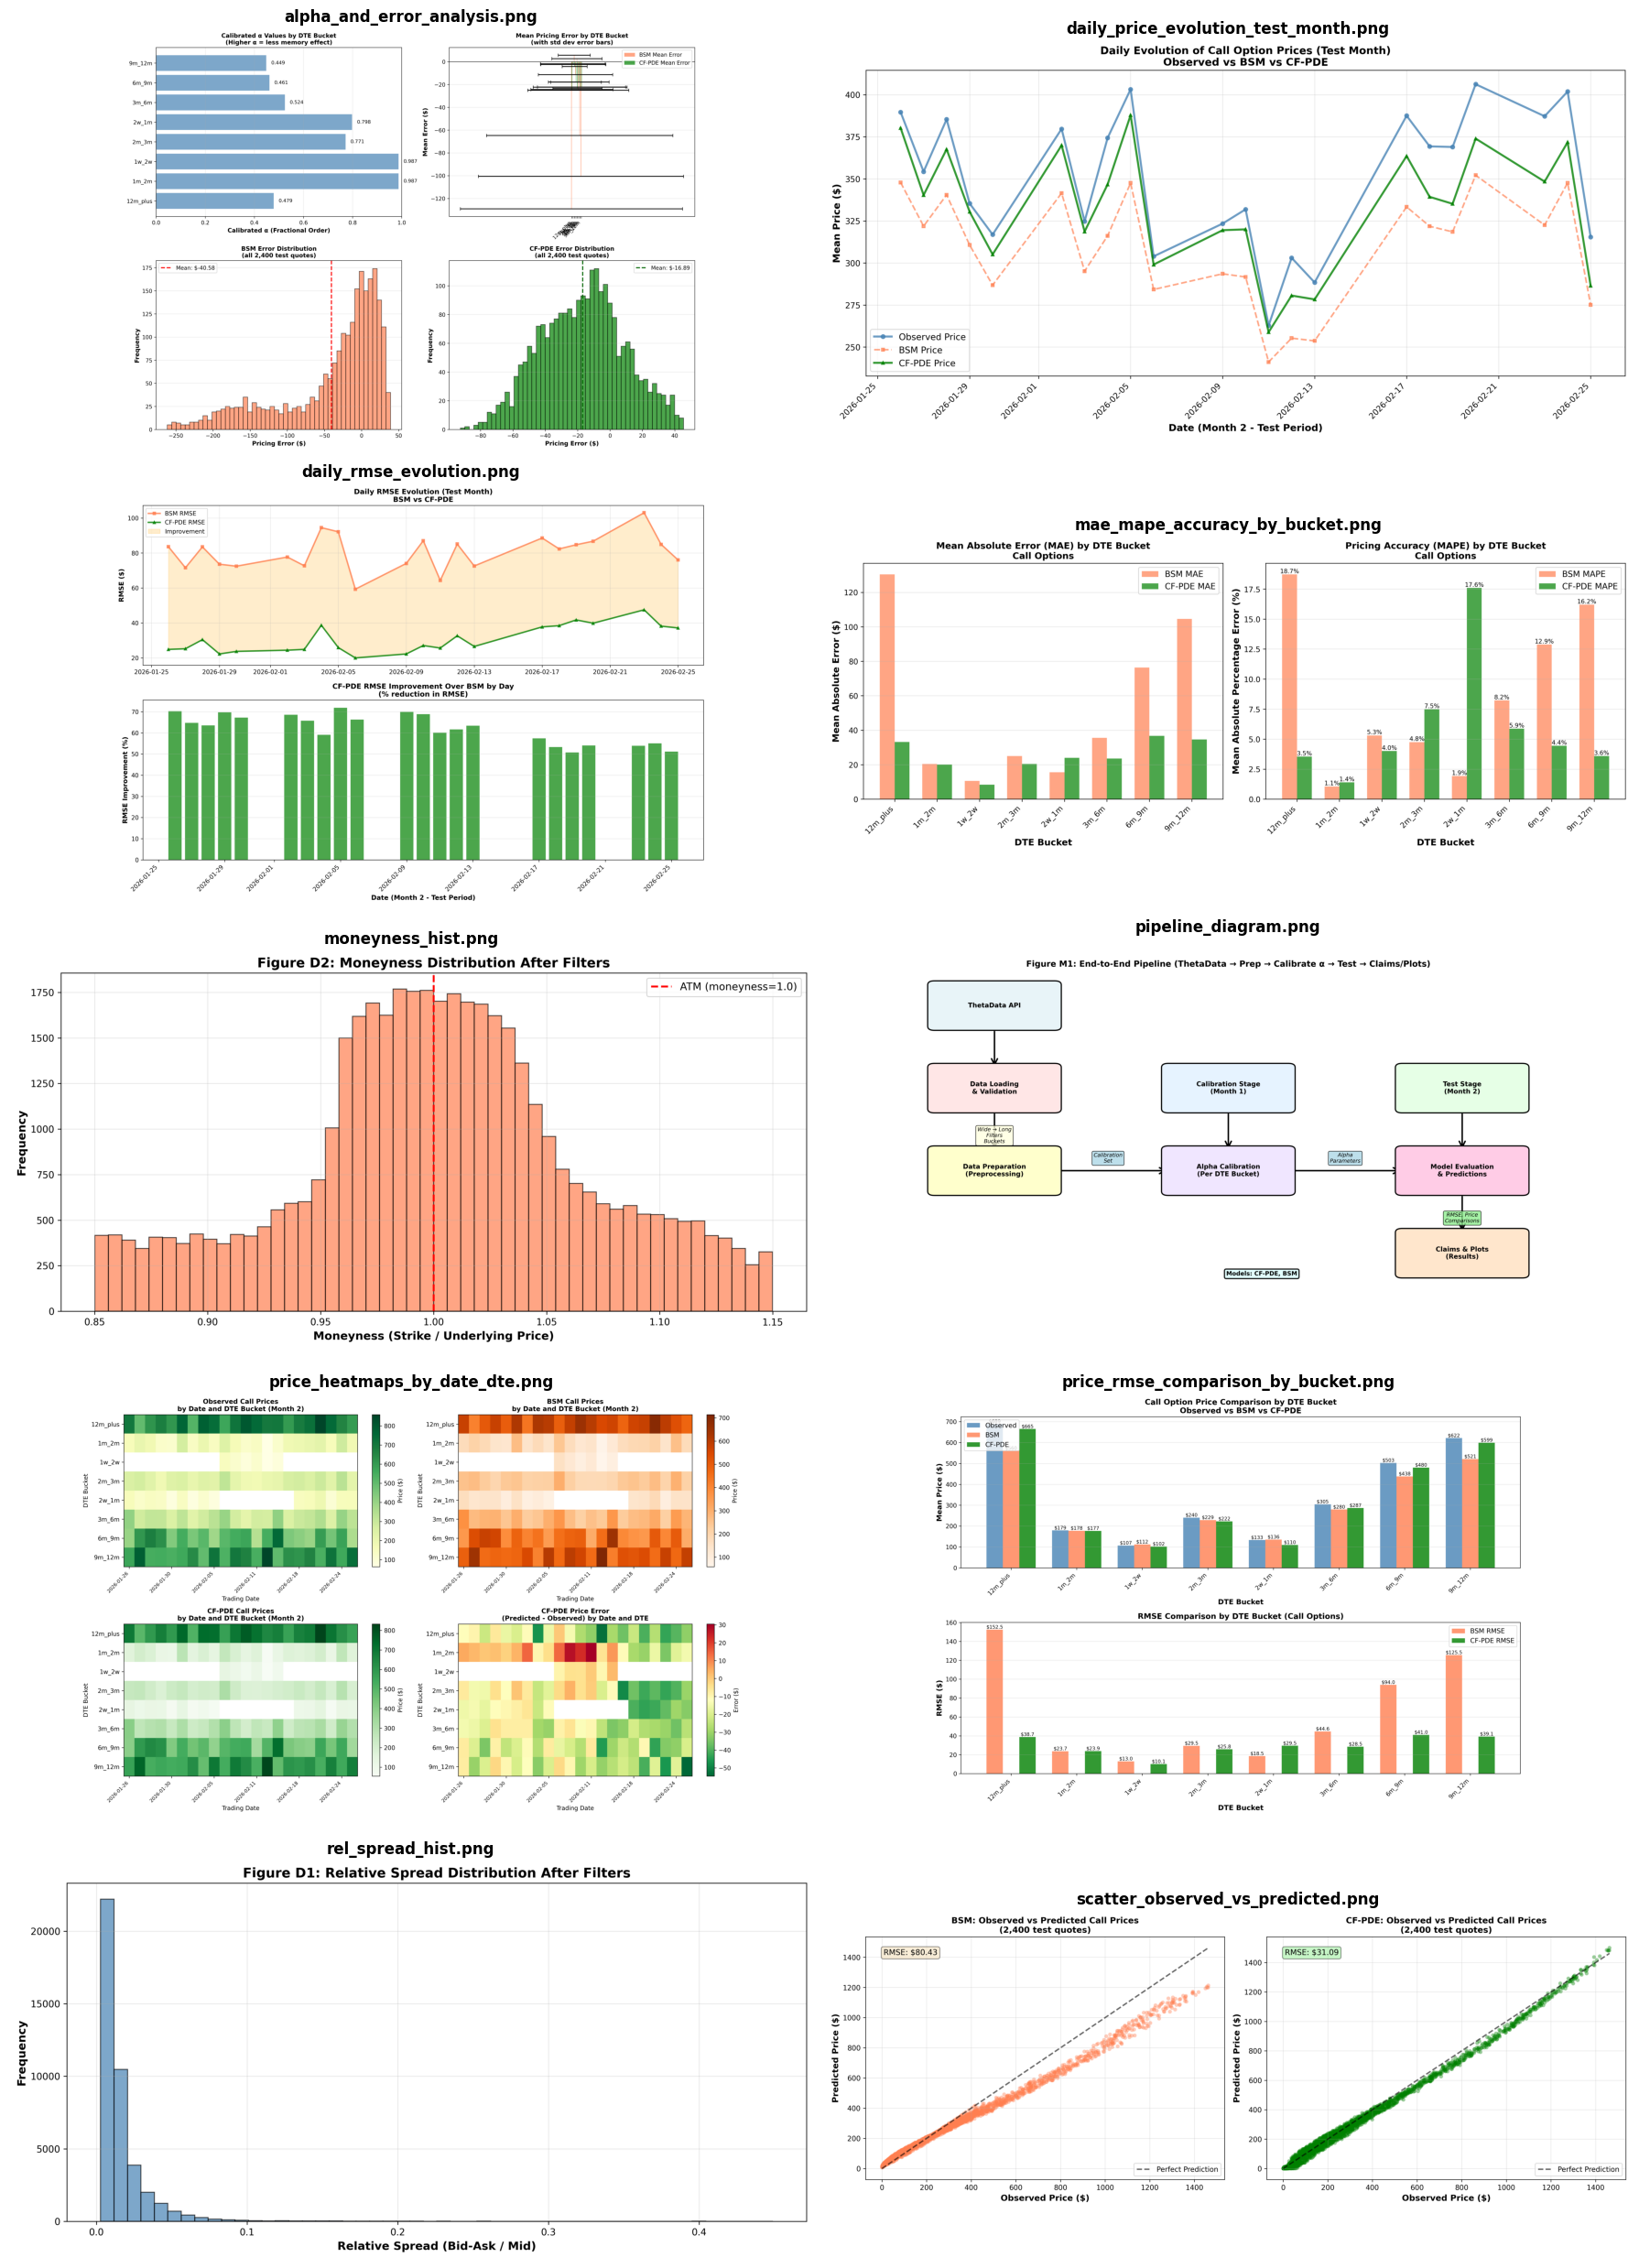


SUMMARY: All plots have been generated and saved:
  ✓ alpha_and_error_analysis.png
  ✓ daily_price_evolution_test_month.png
  ✓ daily_rmse_evolution.png
  ✓ mae_mape_accuracy_by_bucket.png
  ✓ moneyness_hist.png
  ✓ pipeline_diagram.png
  ✓ price_heatmaps_by_date_dte.png
  ✓ price_rmse_comparison_by_bucket.png
  ✓ rel_spread_hist.png
  ✓ scatter_observed_vs_predicted.png


In [9]:
# Load and display all plots from results/plots/
from PIL import Image
import os

plots_dir = project_root / "results" / "plots"
plot_files = sorted([f for f in os.listdir(plots_dir) if f.endswith('.png')])

print(f"\n✓ Found {len(plot_files)} plots in {plots_dir}\n")

# Display plots in a grid
num_plots = len(plot_files)
num_cols = 2
num_rows = (num_plots + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 5*num_rows))
if num_rows == 1:
    axes = axes.reshape(1, -1)

axes_flat = axes.flatten()

for idx, plot_file in enumerate(plot_files):
    plot_path = plots_dir / plot_file
    img = Image.open(plot_path)
    axes_flat[idx].imshow(img)
    axes_flat[idx].set_title(f"{plot_file}", fontsize=12, fontweight='bold')
    axes_flat[idx].axis('off')

# Hide empty subplots
for idx in range(len(plot_files), len(axes_flat)):
    axes_flat[idx].axis('off')

plt.tight_layout()
plt.show()

print(f"\n{'='*80}")
print("SUMMARY: All plots have been generated and saved:")
print(f"{'='*80}")
for plot_file in plot_files:
    print(f"  ✓ {plot_file}")

In [12]:
# ALIGNMENT VERIFICATION: Check 2-Month Split (1 Month Calibration + 1 Month Test)
print("\n" + "="*80)
print("ALIGNMENT VERIFICATION: 2-MONTH PERIOD SPLIT")
print("="*80 + "\n")

# Load the three datasets
try:
    cal_set = pd.read_csv(project_root / "results" / "calibration_set_1m.csv")
    test_set = pd.read_csv(project_root / "results" / "test_set_1m.csv")
    prep_data = pd.read_csv(project_root / "results" / "prepared_long_2m.csv")
    
    # Convert dates
    cal_set['QUOTE_DATE'] = pd.to_datetime(cal_set['QUOTE_DATE'])
    test_set['QUOTE_DATE'] = pd.to_datetime(test_set['QUOTE_DATE'])
    prep_data['QUOTE_DATE'] = pd.to_datetime(prep_data['QUOTE_DATE'])
    
    print("PREPARED DATA (Full 2-Month Period):")
    print(f"  Date Range: {prep_data['QUOTE_DATE'].min().date()} to {prep_data['QUOTE_DATE'].max().date()}")
    print(f"  Total Records: {len(prep_data):,}")
    print(f"  Unique Dates: {prep_data['QUOTE_DATE'].nunique()}")
    
    print("\nCALIBRATION SET (Month 1):")
    print(f"  Date Range: {cal_set['QUOTE_DATE'].min().date()} to {cal_set['QUOTE_DATE'].max().date()}")
    print(f"  Total Records: {len(cal_set):,}")
    print(f"  Unique Dates: {cal_set['QUOTE_DATE'].nunique()}")
    
    print("\nTEST SET (Month 2):")
    print(f"  Date Range: {test_set['QUOTE_DATE'].min().date()} to {test_set['QUOTE_DATE'].max().date()}")
    print(f"  Total Records: {len(test_set):,}")
    print(f"  Unique Dates: {test_set['QUOTE_DATE'].nunique()}")
    
    print("\nVERIFICATION:")
    print(f"  ✓ Cal + Test = {len(cal_set) + len(test_set):,} records")
    print(f"  ✓ Prepared Total = {len(prep_data):,} records")
    
    if len(cal_set) + len(test_set) == len(prep_data):
        print("  ✓ ALIGNED: Calibration + Test = Prepared Data")
    else:
        print("  ❌ MISMATCH: Sum doesn't match prepared data")
    
except Exception as e:
    print(f"Using parquet files instead: {e}")
    cal_set = pd.read_parquet(project_root / "results" / "calibration_set_1m.parquet")
    test_set = pd.read_parquet(project_root / "results" / "test_set_1m.parquet")
    prep_data = pd.read_parquet(project_root / "results" / "prepared_long_2m.parquet")
    
    cal_set['QUOTE_DATE'] = pd.to_datetime(cal_set['QUOTE_DATE'])
    test_set['QUOTE_DATE'] = pd.to_datetime(test_set['QUOTE_DATE'])
    prep_data['QUOTE_DATE'] = pd.to_datetime(prep_data['QUOTE_DATE'])
    
    print("PREPARED DATA (Full 2-Month Period):")
    print(f"  Date Range: {prep_data['QUOTE_DATE'].min().date()} to {prep_data['QUOTE_DATE'].max().date()}")
    print(f"  Total Records: {len(prep_data):,}")
    print(f"  Unique Dates: {prep_data['QUOTE_DATE'].nunique()}")
    
    print("\nCALIBRATION SET (Month 1):")
    print(f"  Date Range: {cal_set['QUOTE_DATE'].min().date()} to {cal_set['QUOTE_DATE'].max().date()}")
    print(f"  Total Records: {len(cal_set):,}")
    print(f"  Unique Dates: {cal_set['QUOTE_DATE'].nunique()}")
    
    print("\nTEST SET (Month 2):")
    print(f"  Date Range: {test_set['QUOTE_DATE'].min().date()} to {test_set['QUOTE_DATE'].max().date()}")
    print(f"  Total Records: {len(test_set):,}")
    print(f"  Unique Dates: {test_set['QUOTE_DATE'].nunique()}")
    
    print("\nVERIFICATION:")
    print(f"  ✓ Cal + Test = {len(cal_set) + len(test_set):,} records")
    print(f"  ✓ Prepared Total = {len(prep_data):,} records")
    
    if len(cal_set) + len(test_set) == len(prep_data):
        print("  ✓ ALIGNED: Calibration + Test = Prepared Data")
    else:
        print("  ❌ MISMATCH: Sum doesn't match prepared data")

print("\n" + "="*80 + "\n")


ALIGNMENT VERIFICATION: 2-MONTH PERIOD SPLIT

PREPARED DATA (Full 2-Month Period):
  Date Range: 2025-12-26 to 2026-02-25
  Total Records: 42,069
  Unique Dates: 41

CALIBRATION SET (Month 1):
  Date Range: 2025-12-26 to 2026-01-23
  Total Records: 19,059
  Unique Dates: 19

TEST SET (Month 2):
  Date Range: 2026-01-26 to 2026-02-25
  Total Records: 23,010
  Unique Dates: 22

VERIFICATION:
  ✓ Cal + Test = 42,069 records
  ✓ Prepared Total = 42,069 records
  ✓ ALIGNED: Calibration + Test = Prepared Data




## Summary: All Outputs

### Tables Created:
- **Table D1** (data_coverage_summary.csv): Raw data coverage with date ranges and contract counts
- **Table D2** (filter_retention_summary.csv): Filter retention rates through data cleaning stages
- **Table D3** (counts_by_bucket.csv): Counts by DTE bucket and option type after filtering

### Figures Created:
- **Figure D1** (rel_spread_hist.png): Relative spread distribution after filters
- **Figure D2** (moneyness_hist.png): Moneyness distribution after filters
- **Figure M1** (pipeline_diagram.png): End-to-end pipeline flowchart

All outputs are saved in `results/tables/` and `results/plots/` directories and are ready for insertion into the paper.